In [1]:
import matplotlib.pyplot as plt
import os
import missingno as msno

os.environ["MODIN_ENGINE"] = "ray"  # Modin will use Ray

# import pandas as pd
import modin.pandas as pd
import ray
ray.init(ignore_reinit_error=True)

import warnings
warnings.filterwarnings("ignore")

In [2]:
%run ./module_P2_utils.ipynb

> important notice : import is made with date type parsing specified for date columns, discovered after preliminary analysis

In [3]:
df = pd.read_csv('en.openfoodfacts.org.products.csv', sep='\t', parse_dates=['created_datetime','last_modified_datetime'])

In [4]:
print(f"dataframe have {df.shape[1]} columns and {df.shape[0]} rows")

dataframe have 186 columns and 1988476 rows


In [5]:
df.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,abbreviated_product_name,generic_name,...,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,00000000000000225,http://world-en.openfoodfacts.org/product/0000...,nutrinet-sante,1623855208,2021-06-16 14:53:28+00:00,1623855209,2021-06-16 14:53:29+00:00,jeunes pousses,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00000000000003429145,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1630483911,2021-09-01 08:11:51+00:00,1630484064,2021-09-01 08:14:24+00:00,L.casei,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0000000000017,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1529059080,2018-06-15 10:38:00+00:00,1561463718,2019-06-25 11:55:18+00:00,Vitória crackers,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0000000000031,http://world-en.openfoodfacts.org/product/0000...,isagoofy,1539464774,2018-10-13 21:06:14+00:00,1539464817,2018-10-13 21:06:57+00:00,Cacao,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,000000000003327986,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1574175736,2019-11-19 15:02:16+00:00,1624390765,2021-06-22 19:39:25+00:00,Filetes de pollo empanado,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Content Discovery

What's inside the dataset ?

In [6]:
df.info()

<class 'modin.pandas.dataframe.DataFrame'>
RangeIndex: 1988476 entries, 0 to 1988475
Columns: 186 entries, code to carnitine_100g
dtypes: float64(124), object(58), int64(2), datetime64[ns, UTC](2)
memory usage: 2.8 GB


In [7]:
for col in range(0, df.columns.size):
    print(f'{df.columns[col]:<45} {str(df.dtypes[col]):>}')

code                                          object
url                                           object
creator                                       object
created_t                                     int64
created_datetime                              datetime64[ns, UTC]
last_modified_t                               int64
last_modified_datetime                        datetime64[ns, UTC]
product_name                                  object
abbreviated_product_name                      object
generic_name                                  object
quantity                                      object
packaging                                     object
packaging_tags                                object
packaging_text                                object
brands                                        object
brands_tags                                   object
categories                                    object
categories_tags                               object
categories_en         

<AxesSubplot:title={'center':'repartition of features type in dataset'}, ylabel='None'>

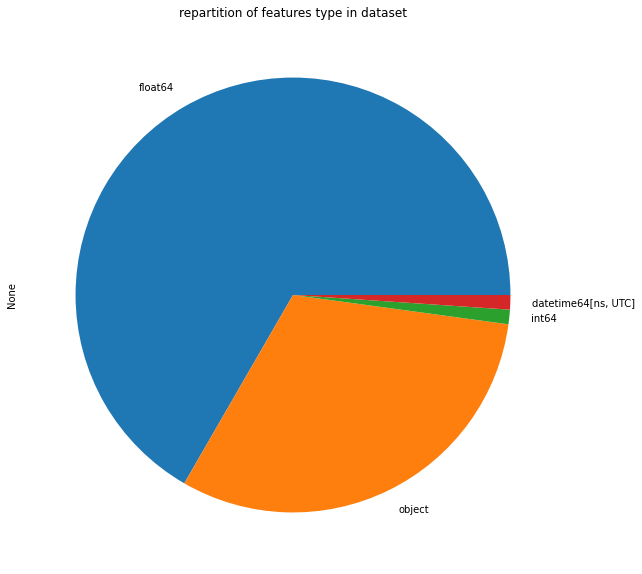

In [8]:
plt.figure(figsize=(10,10))
df.dtypes.value_counts().plot.pie(title="repartition of features type in dataset")

Most of the features are qualitative or quantitative. 
Just a few of them are date / time based or integers

# CLEANING

In this Chapter, we will:
* investigate minority categories
* remove empty features
* remove some of the features (columns) that don't have much interest.
* remove obvious and non sense values


## Minority Categories : Investigate `int` and `date` features


In [9]:
df.columns[((df.dtypes != 'float') & (df.dtypes != 'object'))]

Index(['created_t', 'created_datetime', 'last_modified_t',
       'last_modified_datetime'],
      dtype='object')

In [10]:
df.dtypes[['created_t','created_datetime','last_modified_t', 'last_modified_datetime']]

created_t                               int64
created_datetime          datetime64[ns, UTC]
last_modified_t                         int64
last_modified_datetime    datetime64[ns, UTC]
dtype: object

In [11]:
df[['created_t', 'created_datetime', 'last_modified_t', 'last_modified_datetime']].head()

,created_t,created_datetime,last_modified_t,last_modified_datetime
0,1623855208,2021-06-16 14:53:28+00:00,1623855209,2021-06-16 14:53:29+00:00
1,1630483911,2021-09-01 08:11:51+00:00,1630484064,2021-09-01 08:14:24+00:00
2,1529059080,2018-06-15 10:38:00+00:00,1561463718,2019-06-25 11:55:18+00:00
3,1539464774,2018-10-13 21:06:14+00:00,1539464817,2018-10-13 21:06:57+00:00
4,1574175736,2019-11-19 15:02:16+00:00,1624390765,2021-06-22 19:39:25+00:00


In [12]:
pd.to_datetime(df['created_t'], unit='s').head()

0   2021-06-16 14:53:28
1   2021-09-01 08:11:51
2   2018-06-15 10:38:00
3   2018-10-13 21:06:14
4   2019-11-19 15:02:16
Name: created_t, dtype: datetime64[ns]

As we can see, columns are the same between X_datetime and X_t, so we choose to remove one of them

In [13]:
df.drop({
    'created_t', 
    'last_modified_t', 
        }, axis=1, inplace=True)

## Removal of Empty features

let's compute the ratio: $ \frac{\text{empty values}}{\text{nb rows}} $

<AxesSubplot:ylabel='Frequency'>

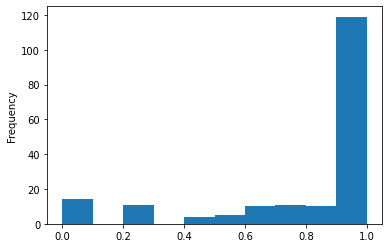

In [14]:
df.sample(round(df.shape[0]*0.02)).isna().mean().sort_values().plot(kind="hist")

About 120 out of 186 columns have more than 80% of empty cells. The dataset despite being large, is almost empty !

<AxesSubplot:>

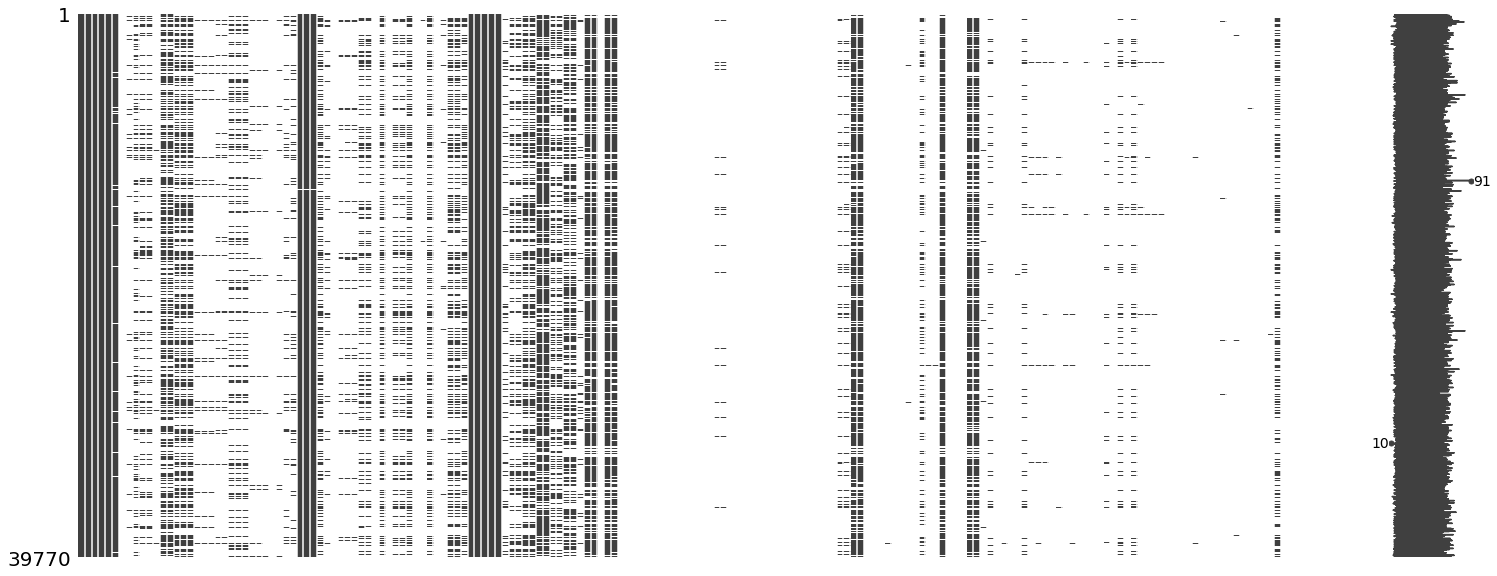

In [15]:
msno.matrix(df.sample(round(df.shape[0]*0.02)))

Taking a sample (20%) of the dataset, to ease compute, we can see there are some plateau of columns missing data, let's consider we want to remove at least those that have more than 70% of missing value.

In [16]:
threshold = 0.7
df = df[df.columns[df.isna().mean() < threshold]]

(apply_func pid=285217) 


## Removal of Not Interesting features

Some features provides values that won't be of interest for future analysis, we remove them manually.

For instance, we decide that features providing `url` are removed

In [17]:
url_columns = df.filter(regex='url').columns.values
print(url_columns)
df = df.drop(url_columns, axis=1)

['url' 'image_url' 'image_small_url' 'image_ingredients_url'
 'image_ingredients_small_url' 'image_nutrition_url'
 'image_nutrition_small_url']


## Obvious Out of Range Values

Provided file [input/data-fields.txt]() explains some of the features maximum and minimum values. For instance most of values `*_100g` have boundaries [0; 100].

> - fields that end with _100g correspond to the amount of a nutriment (in g, or kJ for energy) for 100 g or 100 ml of product

So, values out of this boundaries should be removed, for instance we can't have more than 100g of fat in a portion of 100g.

Despite:
* `energy*` values are not to be considered the same since the unit is not the same (kJ per 100g)
* `nutrition_score_fr_100g` hasn't to be considered the same since it is a score, not a ratio of ingredient in a portion

Documentation also states that quantitative values `*_n` are not continuous, therefore we should consider them as discrete and categorical features.

Finally, for continuous values, we may replace NaN values by 0.0

In [18]:
cols100g = df.filter(regex="_100g").columns

cols100g_bounded = cols100g.drop(['energy-kcal_100g', 'energy_100g', 'nutrition-score-fr_100g'])
cols100g_bounded

Index(['fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g',
       'proteins_100g', 'salt_100g', 'sodium_100g'],
      dtype='object')

### Fill Nan Values

For **continuous** quantitative features

In [19]:
df.select_dtypes('float').columns

Index(['additives_n', 'ingredients_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_n', 'nutriscore_score',
       'nova_group', 'energy-kcal_100g', 'energy_100g', 'fat_100g',
       'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g',
       'proteins_100g', 'salt_100g', 'sodium_100g', 'nutrition-score-fr_100g'],
      dtype='object')

In [20]:
quantis_nullable =['nutriscore_score', 'nova_group']
quantis_non_nullable = df.select_dtypes('float').columns.drop(quantis_nullable)

In [21]:
df.fillna({col:0.0 for col in quantis_non_nullable}, inplace=True)

### Remove Out of Range Values

In [22]:
rogues = pd.DataFrame(
    [
        (df[cols100g_bounded] < 0).sum(),
        (df[cols100g_bounded] > 100).sum(),
        ((df[cols100g_bounded] < 0).sum() + (df[cols100g_bounded] > 100).sum())
    ],
    index=['negatives', 'greater_100', 'to_remove'],
    columns=cols100g_bounded
)
rogues.loc['Column_Total']= rogues.sum(numeric_only=True, axis=0)
rogues.loc[:,'Row_Total'] = rogues.sum(numeric_only=True, axis=1)
rogues

(compute_sliced_len pid=285212) 


,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,sodium_100g,Row_Total
negatives,0.0,0.0,2.0,5.0,2.0,0.0,0.0,9.0
greater_100,209.0,79.0,300.0,120.0,139.0,1044.0,702.0,2593.0
to_remove,209.0,79.0,302.0,125.0,141.0,1044.0,702.0,2602.0
Column_Total,418.0,158.0,604.0,250.0,282.0,2088.0,1404.0,5204.0


As we can see, just a few values are inconsistent and one can consider removing them wouldn't be necessary. This is misleading, since those values may have a great impact on the features' distribution.

Now the question is : *"What to do with these values ?"*

Several options exists:
* removing the row which contains such value
* replacing the value with NaN ? or with another value ?

This decision must be done carefully because either we may end up to remove lots of rows, or we would be modifying the 'meaning' of the data.

Let's investigate the two options

#### 1. Removing rows


In [23]:
# tmpdf = df.copy()
# df = tmpdf.copy()

In [24]:
initial_size = df.shape[0]
print(initial_size)
for col in cols100g_bounded:
    df = df[(df[col] <= 100) & (df[col] >= 0)]
final_size = df.shape[0]
print(final_size)
print(f"removed {initial_size - final_size} rows")

1988476
1986910
removed 1566 rows


#### 2. Replacing with arbitrary values

Since removal above didn't had too much impacts on the dataset, we don't have to prospect this option.

## Remove duplicates

We use `code` as the primary key in our dataset, thus we expect no duplicate values on this column

In [25]:
df.loc[df.duplicated(['code'])]

,code,creator,created_datetime,last_modified_datetime,product_name,brands,brands_tags,categories,categories_tags,categories_en,...,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g
281860,9542031695,foodrepo,2019-01-29 13:03:30+00:00,2019-08-28 16:02:29+00:00,Dark chocolate,Lindt excellence,lindt-excellence,NaN,NaN,NaN,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.000000,0.0
339897,273,openfoodfacts-contributors,2018-09-14 20:19:55+00:00,2018-09-14 20:19:56+00:00,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.000000,0.0
362958,616618002307,org-database-usda,2020-04-23 13:22:37+00:00,2020-04-23 13:22:37+00:00,Lemon orange napolitanke,NaN,NaN,"Snacks, Sweet snacks, Biscuits and cakes, Bisc...","en:snacks,en:sweet-snacks,en:biscuits-and-cake...","Snacks,Sweet snacks,Biscuits and cakes,Biscuits",...,500.000000,2092.0,25.0,12.5,60.000000,40.0,5.000000,0.06250,0.025000,24.0
363744,619325,tacinte,2014-08-27 21:19:25+00:00,2021-01-13 18:01:19+00:00,Ground cinnamon,Marks & Spencer,marks-spencer,"Plant-based foods and beverages, Plant-based f...","en:plant-based-foods-and-beverages,en:plant-ba...","Plant-based foods and beverages,Plant-based fo...",...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.000000,0.0
372234,635646,beniben,2016-09-22 05:15:44+00:00,2020-09-24 10:59:20+00:00,Chargrilled Vegetable & Basil Pesto,"M&S,Marks & Spencer","m-s,marks-spencer","Plats préparés, Pizzas tartes salées et quiche...","en:meals,en:pizzas-pies-and-quiches,en:pizzas,...","Meals,Pizzas pies and quiches,Pizzas,Vegetable...",...,200.000000,841.0,7.8,2.5,23.400000,3.9,8.400000,0.95000,0.380000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1952260,898999000022,foodrepo,2019-01-29 11:58:17+00:00,2019-09-19 08:06:26+00:00,Vita Coco natural coconut water,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.000000,0.0
1952534,899277,kiliweb,2019-04-13 15:21:40+00:00,2019-04-13 15:21:40+00:00,Piccolini tomatoes,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.000000,0.0
1952807,899468,kiliweb,2019-07-30 11:13:02+00:00,2019-07-30 11:13:02+00:00,Salade Trois Haricots,NaN,NaN,NaN,NaN,NaN,...,114.000000,477.0,1.8,0.3,14.800000,2.1,6.500000,0.53000,0.212000,0.0
1953324,9,elcoco,2020-03-11 05:51:56+00:00,2020-03-13 19:59:03+00:00,NaN,NaN,NaN,Mantequillas,"en:dairies,en:spreads,en:fats,en:spreadable-fa...","Dairies,Spreads,Fats,Spreadable fats,Animal fa...",...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.000000,0.0


About 500 values will be removed, very few compared to the size of the dataset

In [26]:
df.drop_duplicates('code', inplace=True)

## Results of cleaning

In [27]:
df.shape

(1986648, 37)

<AxesSubplot:ylabel='None'>

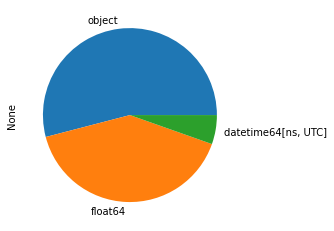

In [28]:
df.dtypes.value_counts().plot.pie()

<AxesSubplot:title={'center':'percentage of missing values per feature'}>

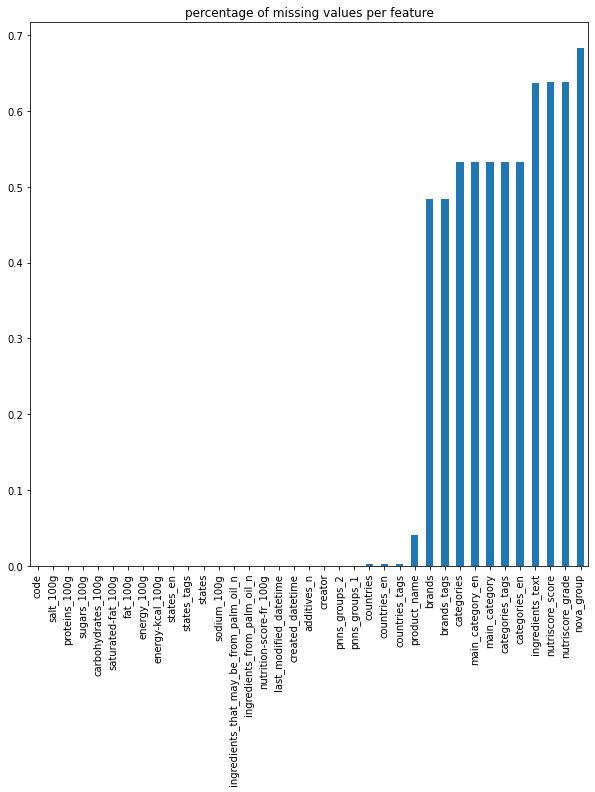

In [29]:
df.isna().mean().sort_values().plot(kind="bar", title='percentage of missing values per feature', figsize=(10,10))

In [30]:
pd.DataFrame({'type': df.dtypes, 'percent_missing_value': df.isna().mean() * 100}).sort_values(by=['percent_missing_value'])

,type,percent_missing_value
code,object,0.000000
salt_100g,float64,0.000000
proteins_100g,float64,0.000000
sugars_100g,float64,0.000000
carbohydrates_100g,float64,0.000000
saturated-fat_100g,float64,0.000000
fat_100g,float64,0.000000
energy_100g,float64,0.000000
energy-kcal_100g,float64,0.000000
states_en,object,0.000000


# Conclusion on Exploratory Data Analysis

## What's provided ?

This dataset has a mix of different kinds of data.

### Size / Nb lines & columns

It has almost 2 Mio raw values with 186 features. despite, after cleaning only 37 columns remains.

### Features Comprehension

It contains a mix of types : dates, strings, numbers

       
#### Qualitative / Categorical
code
creator
created_datetime
last_modified_datetime
product_name
brands
brands_tags
categories
categories_tags
categories_en
countries
countries_tags
countries_en
ingredients_text
states
states_tags
states_en
main_category
main_category_en

##### Ordinal Categories
additives_n
ingredients_from_palm_oil_n
ingredients_that_may_be_from_palm_oil_n

nutriscore_grade

nova_group [explanation (fr)](https://www.thierrysouccar.com/nutrition/info/nova-une-classification-des-aliments-basee-sur-la-science-3936)
pnns_groups_1 [explanation (fr)](https://solidarites-sante.gouv.fr/IMG/pdf/pnns4_2019-2023.pdf)
pnns_groups_2



#### Quantitative

nutriscore_score
energy-kcal_100g
energy_100g
fat_100g
saturated-fat_100g
carbohydrates_100g
sugars_100g
proteins_100g
salt_100g
sodium_100g
nutrition-score-fr_100g


In [31]:
df.to_pickle("./tmp/df_01_cleaned.gzip")